<a href="https://colab.research.google.com/github/bye23mj/BERT/blob/main/2021_03_15_KcBERT_MLM_Finetune_with_Petition_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 필요한 패키지 설치

- Korpora: 데이터셋 다운로드
- emoji: 이모지코드
- soynlp: Preprocesisng
- kss: 한국어 문장 분리기
- transformers: MLM 학습 및 데이터셋
  - datasets
  - protobuf
  - sentencepiece

In [ ]:
!pip install -q Korpora emoji soynlp "kss<2.6" transformers "datasets >= 1.1.3" "sentencepiece != 0.1.92" protobuf

     |████████████████████████████████| 65 kB 2.5 MB/s 


# 예시용 데이터셋 다운로드

- 여기서는 Korean petitions dataset(국민청원 데이터셋)을 사용
- 전체 중 동의 수가 1000건 초과인 본문만 사용

In [ ]:
from Korpora import Korpora

In [ ]:
Korpora.fetch('korean_petitions', root_dir='./Korpora')

[Korpora] Corpus `korean_petitions` is already installed at /content/Korpora/korean_petitions/petitions_2017-08
[Korpora] Corpus `korean_petitions` is already installed at /content/Korpora/korean_petitions/petitions_2017-09
[Korpora] Corpus `korean_petitions` is already installed at /content/Korpora/korean_petitions/petitions_2017-10
[Korpora] Corpus `korean_petitions` is already installed at /content/Korpora/korean_petitions/petitions_2017-11
[Korpora] Corpus `korean_petitions` is already installed at /content/Korpora/korean_petitions/petitions_2017-12
[Korpora] Corpus `korean_petitions` is already installed at /content/Korpora/korean_petitions/petitions_2018-01
[Korpora] Corpus `korean_petitions` is already installed at /content/Korpora/korean_petitions/petitions_2018-02
[Korpora] Corpus `korean_petitions` is already installed at /content/Korpora/korean_petitions/petitions_2018-03
[Korpora] Corpus `korean_petitions` is already installed at /content/Korpora/korean_petitions/petitions_

In [ ]:
from glob import glob

In [ ]:
dataset = glob('./Korpora/korean_petitions/petitions*')
dataset

['./Korpora/korean_petitions/petitions_2018-06',
 './Korpora/korean_petitions/petitions_2018-05',
 './Korpora/korean_petitions/petitions_2018-01',
 './Korpora/korean_petitions/petitions_2017-11',
 './Korpora/korean_petitions/petitions_2017-09',
 './Korpora/korean_petitions/petitions_2018-10',
 './Korpora/korean_petitions/petitions_2019-03',
 './Korpora/korean_petitions/petitions_2019-02',
 './Korpora/korean_petitions/petitions_2018-03',
 './Korpora/korean_petitions/petitions_2017-08',
 './Korpora/korean_petitions/petitions_2019-01',
 './Korpora/korean_petitions/petitions_2018-11',
 './Korpora/korean_petitions/petitions_2018-09',
 './Korpora/korean_petitions/petitions_2018-07',
 './Korpora/korean_petitions/petitions_2017-10',
 './Korpora/korean_petitions/petitions_2018-12',
 './Korpora/korean_petitions/petitions_2018-02',
 './Korpora/korean_petitions/petitions_2018-08',
 './Korpora/korean_petitions/petitions_2018-04',
 './Korpora/korean_petitions/petitions_2017-12']

# 데이터 로딩

- pandas로 `content` 부분만 읽어 파일로 만들기
- kss로 각 청원 게시글 내 문장 분리 


In [ ]:
import pandas as pd
from tqdm.auto import tqdm

In [ ]:
df = pd.concat([pd.read_json(i, lines=True) for i in tqdm(dataset)])

  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
df.head()

,category,begin,end,content,num_agree,petition_idx,status,title,replies
0,미래,2018-06-01,2018-07-01,"중국과 5년간 일때문에 교류를 하면서, 통역을 맡은 아가씨들이 모두 조선족아가씨 였...",9,257860,청원종료,조선족은 중국사람 입니다!,NaN
1,기타,2018-06-01,2018-07-01,안녕하세요 저는 18세 남자입니다 요즘 페북이나 청와대 홈페이지를 통해 청원들을 보...,3,257861,청원종료,청원의 문제점,NaN
2,문화/예술/체육/언론,2018-06-01,2018-07-01,어제 오늘 중계보고 있으려니 속터지네요 감독작전도 무대책 ᆢ리시브 기본도 없는 선수...,0,257862,청원종료,여자대표 철수해주세요,NaN
3,정치개혁,2018-06-01,2018-07-01,대통령님 덕분에 우리나라가 좋아졌다는걸 느껴요 항상 국민 옆에 계셔야 해요!,0,257863,청원종료,문대통령님 오랫동안 대통령하시면 안될까요?,NaN
4,육아/교육,2018-06-01,2018-07-01,급식이 너무 맛이 없고 가격도 비싸서 재원생의 원성이 자자합니다. 알고보니 급식업체...,34,257864,청원종료,시대인재학원 급식 좀 맛있게 해주세요,NaN


In [ ]:
len(df)

433631

In [ ]:
agreed_df = df[df['num_agree'] > 1000]

In [ ]:
len(agreed_df)

3704

In [ ]:
import re
import emoji
from soynlp.normalizer import repeat_normalize

emojis = ''.join(emoji.UNICODE_EMOJI.keys())
pattern = re.compile(f'[^ .,?!/@$%~％·∼()\x00-\x7Fㄱ-ㅣ가-힣{emojis}]+')
url_pattern = re.compile(
    r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)')

def clean(x):
    x = pattern.sub(' ', x)
    x = url_pattern.sub('', x)
    x = x.strip()
    x = repeat_normalize(x, num_repeats=2)
    return x

In [ ]:
contents = agreed_df['content'].map(clean).to_list()

In [ ]:
from kss import split_sentences

In [ ]:
import os

In [ ]:
split_sentences("안녕하세요. 오늘은 날씨가 좋더라구요.")

['안녕하세요.', '오늘은 날씨가 좋더라구요.']

In [ ]:
with open('korean_petitions_safe.txt', 'w') as f:
    for doc in tqdm(contents):
        if doc:
            for line in split_sentences(doc):
                f.write(line+'\n')
            f.write('\n')
    f.close()

  0%|          | 0/3704 [00:00<?, ?it/s]

TypeError: ignored

# KcBERT-base MLM Finetune 학습하기 (GPU)

- Huggingface Transformers에서 제공하는 `run_mlm.py` 파일을 이용해 KcBERT weight과 vocab을 이용해 MLM 학습 

In [ ]:
!mkdir ./test-mlm

mkdir: cannot create directory ‘./test-mlm’: File exists


In [ ]:
!wget -O run_mlm.py https://raw.githubusercontent.com/huggingface/transformers/72aee83ced5f31302c5e331d896412737287f976/examples/pytorch/language-modeling/run_mlm.py

--2021-08-16 05:39:13--  https://raw.githubusercontent.com/huggingface/transformers/72aee83ced5f31302c5e331d896412737287f976/examples/pytorch/language-modeling/run_mlm.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24078 (24K) [text/plain]
Saving to: ‘run_mlm.py’

run_mlm.py          100%[===================>]  23.51K  --.-KB/s    in 0.002s  

2021-08-16 05:39:14 (15.1 MB/s) - ‘run_mlm.py’ saved [24078/24078]



In [ ]:
!nvidia-smi

Mon Aug 16 05:39:14 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!ls

korean_petitions_safe.txt	Korpora     sample_data
korean_petitions_safe.txt.lock	run_mlm.py  test-mlm


In [ ]:
!head -n 10 korean_petitions_safe.txt

In [ ]:
!python run_mlm.py \
    --model_name_or_path beomi/kcbert-base \
    --train_file korean_petitions_safe.txt \
    --do_train \
    --output_dir ./test-mlm

2021-08-16 05:39:15.893093: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
08/16/2021 05:39:17 - WARNING - __main__ - Process rank: -1, device: cuda:0, n_gpu: 1distributed training: False, 16-bits training: False
08/16/2021 05:39:17 - INFO - __main__ - Training/evaluation parameters TrainingArguments(
_n_gpu=1,
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_pin_memory=True,
ddp_find_unused_parameters=None,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=False,
do_predict=False,
do_train=True,
eval_accumulation_steps=None,
eval_steps=None,
evaluation_strategy=IntervalStrategy.NO,
fp16=False,
fp16_backend=auto,
fp16_full_eval=False,
fp16_opt_level=O1,
gradient_accumulation_steps=1,
greater_is_better=None,
group_by_length=False,
ignore_data_skip=False,
label_names=None,
label_smoothing_factor=0.0,
learning_rate=5e-05,
length_

### 학습 완료후 아래 에러는 무시하셔도 됩니다.

- 학습 완료된 파일들은 `test-mlm` 폴더 내에 들어있습니다 :)


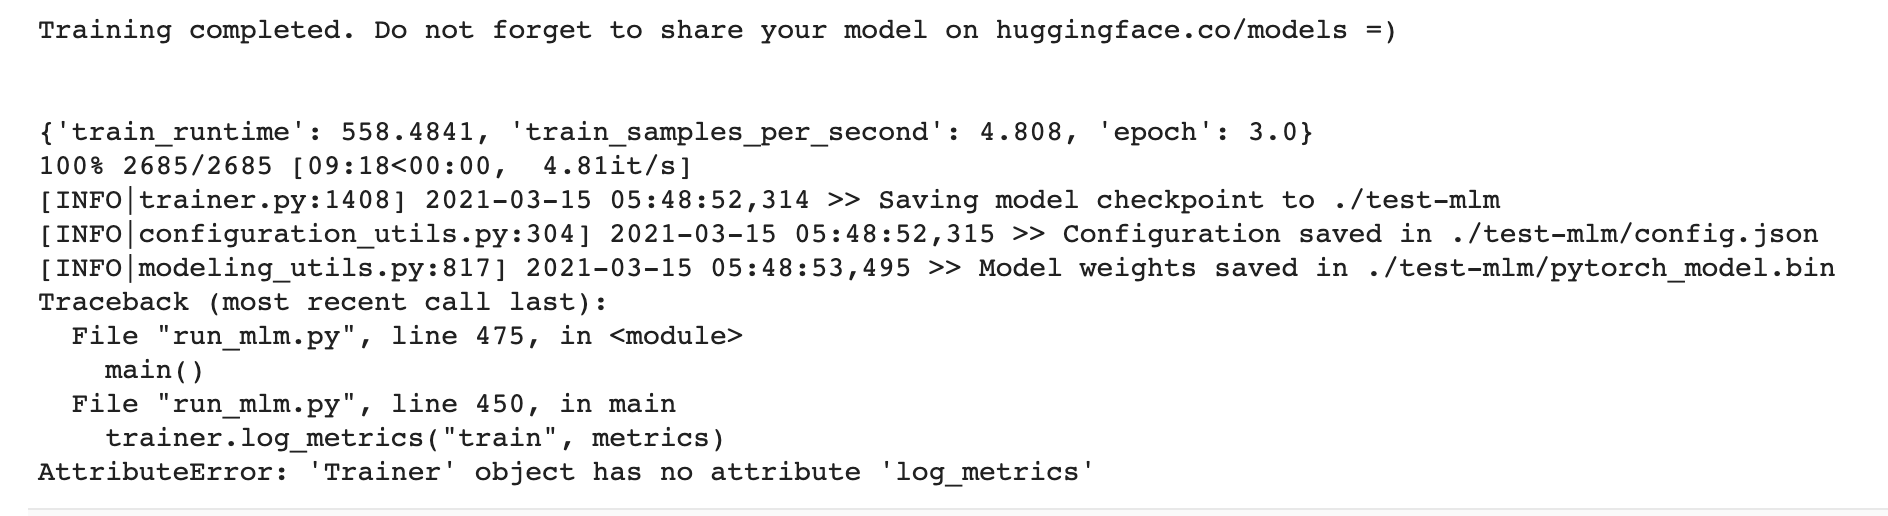